# Initial Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
FILENAMES = ['participants','blood_pressure','heart_rate','hrv_measurements','surveys','scales_description','sleep','wearables','weather']
URL = 'https://raw.githubusercontent.com/Welltory/hrv-covid19/master/data/'
EXTENSION = '.csv'
dfs = {}
for fn in FILENAMES:
  dfs[fn] = pd.read_csv(URL + fn + EXTENSION)

# COVID Preprocessing and Feature Extraction
1. Maps specific survey responses to 0 or 1, 0 being low liklihood of COVID, 1 being liklihood of COVID
2. Envelopes responses to get an aproximate start and stop time for symptoms. 

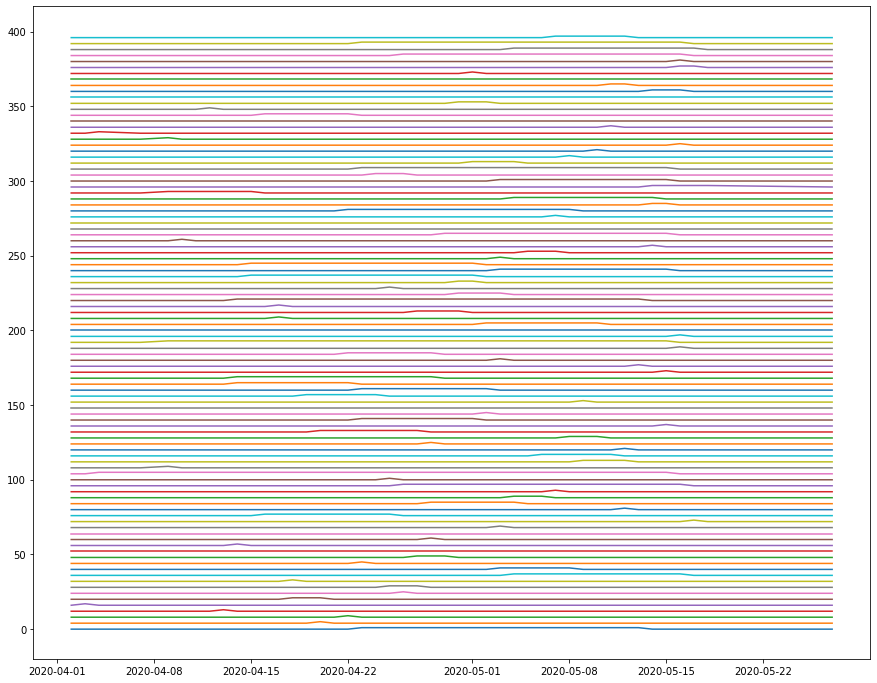

In [ ]:
# Mapping for covid variables
# https://github.com/Welltory/hrv-covid19/blob/master/data/scales_description.csv
vals = {'H': 1, 'M': 1, 'L': 0}
keys = ['S_CORONA', 'S_COVID_OVERALL'] 
maps = [{1: 'H', 2: 'H', 3: 'M', 4: 'L', 5: 'L'},
        {1: 'L', 2: 'M', 3: 'M', 4: 'H', 5: 'H', 6: 'H'}]

# Initial processing 
df = dfs['surveys'].copy()
df['created_at'] = pd.to_datetime(df['created_at'])
df = df.loc[df['scale'].isin(keys)]
for i, key in enumerate(keys):
  df.loc[df['scale'] == key, 'value'] = df.loc[df['scale'] == key, 'value'].map(maps[i])
df = df.drop(columns=['text', 'scale'])
df = df.replace({'value': vals})

# Pivot to make index the userid and columns each day
df = df.copy().pivot_table(index='user_code', columns='created_at', values='value', aggfunc=np.max).fillna(0)
df = df.reset_index()
df = df.set_index('user_code')
df.columns.name = None
df.index.name = None

# Pad an extra day for envelope
df.insert(0, min(df) - timedelta(1), 0.0)
df.insert(0, max(df) + timedelta(1), 0.0)

# Envelope covid data 
def env(y):
  y1 = y.replace(to_replace=0, method='ffill')
  y2 = y.replace(to_replace=0, method='bfill')
  y3 = y1 & y2
  return y3
df = df.astype('int').apply(lambda y: env(y), axis=1)

# # Remove empty rows
# df = df[(df!=0).any(1)].copy()

# # Remove rows where covid symptoms are less than 1 week
# df = df[df.sum(axis=1) > 7].copy();

# Plot
# Each line is a survey response
plt.figure(figsize=(15,12))
for i in range(len(df)):
  x = df.iloc[i,1:].index
  y = df.iloc[i,1:].values + i*4
  plt.plot(x, y)

# Save for later
df_covid = df.copy()

#print(df_covid.head())

# HRV Preprocessing

Output: df_hrv_pp - a dictionary of {user_code : dataframe}

Each dataframe contains the HRV time series of that particular user

One random participant's HRV is plotted at the end

Extracted: 41 participants


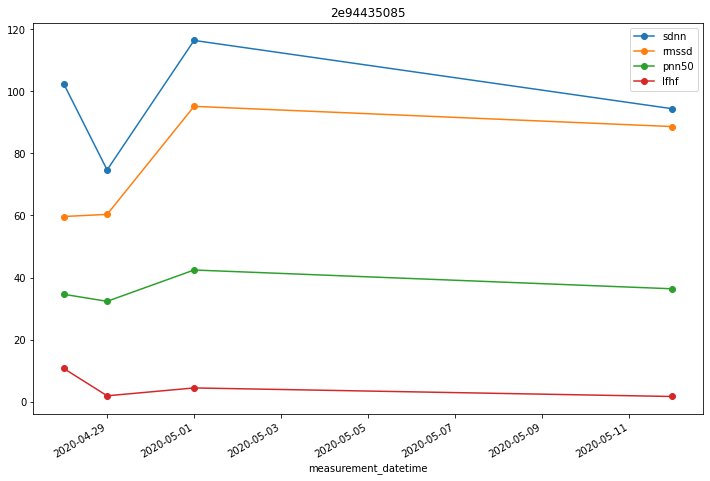

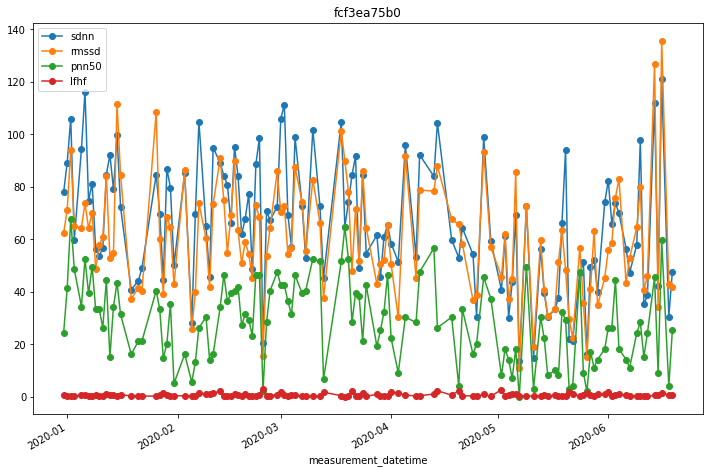

In [ ]:
# HRV Data (Colman)

df_hrv = dfs['hrv_measurements']

# print the columns to see what data does it have
#print(df_hrv.columns)

# let's look at the datetime column 
#print(df_hrv['measurement_datetime'].unique())

# We get a list of dates and use it as the x-axis of the time series (TODO: probably need a better way)
#dlist = pd.to_datetime(df_hrv['measurement_datetime']).dt.date
#dlist = pd.to_datetime(dlist).dt.normalize() # convert from object to datetime[ns]
#dlist = dlist.unique() # turns out only 172 days have measurements

# Note that the measurement is in date + time, but we are predicting the onset date only
# so we have to combine measurement of the same date into one

# get list of column names for new dataframes
#column_names = df_hrv.columns
#column_names = column_names.drop(labels=['user_code', 'measurement_datetime']) # remove unnecessary columns

# prepare to construct a dataframe for each participant (TODO: is there better approach for a 3D dataframe?)
df_hrv_pp = {}
# get list of participants
plist = df_hrv['user_code'].unique()

# start with an naive approach: we only get the first entry and drop the remaining ones
# (i.e., we take the first measurement of the day to represent the whole day)
# iterate participant
for p in plist:
  # filter out measurements and drop NaN
  tmp = df_hrv.loc[df_hrv['user_code'] == p].copy().dropna()

  # TODO drop data if it does not fulfill requirement (e.g., less than 5 entries)
  if tmp.shape[0] < 5:
    continue
  
  # convert datetime to date only
  tmp['measurement_datetime'] = pd.to_datetime(tmp['measurement_datetime']).dt.date
  tmp['measurement_datetime'] = pd.to_datetime(tmp['measurement_datetime']).dt.normalize() # convert from object to datetime[ns]
  #tmp['measurement_datetime'] =  tmp['measurement_datetime'].dt.strftime('%Y-%m-%d')
  # drop user_code column
  tmp = tmp.drop(columns=['user_code', 'rr_code', 'time_of_day', 'how_feel', 'how_mood', 'how_sleep', 'rr_data', 'tags'])

  # set date time as key
  tmp.set_index('measurement_datetime', inplace=True)

  # check if datetime is unique
  if not tmp.index.is_unique:
    # calculate mean for duplicates
    tmp = tmp.reset_index().pivot_table(columns=["measurement_datetime"]).T

  # drop duplicates
  #tmp.drop_duplicates(keep='first')

  # set dataframe
  df_hrv_pp[p] = tmp

print("Extracted: " + str(len(df_hrv_pp)) + " participants")

# let's randomly plot one participant
import random
user_code, df_hrv_random = random.choice(list(df_hrv_pp.items()))

#print(df_hrv_random)
df_hrv_random.plot(y=['sdnn','rmssd','pnn50','lfhf'], kind='line', marker='o', figsize=(12, 8), title=user_code)

# also, fcf3ea75b0 is interesting to look at
user_code = 'fcf3ea75b0'
df_hrv_pp[user_code].plot(y=['sdnn','rmssd','pnn50','lfhf'], kind='line', marker='o', figsize=(12, 8), title=user_code)

# Sleep Preprocessing

In [ ]:
# Sleep data (Hunter)
# 1. Bring in sleep data
# 2. Filter by patient ID and dates
# 3. Prepare dataframe for LR or other ML model

#print(df_covid)

old_df_sleep = dfs['sleep']
# drop columns that aren't filled for all users
old_df_sleep = old_df_sleep.drop(columns=['sleep_awake_duration', 'sleep_rem_duration', 'sleep_light_duration', 'sleep_deep_duration'])
old_df_sleep = old_df_sleep.drop(columns=['pulse_min', 'pulse_max', 'pulse_average'])
old_df_sleep = old_df_sleep.drop(columns=['sleep_begin', 'sleep_end'])
# assign 1 if user_code is in df_p, 0 if not
old_df_sleep = old_df_sleep.assign(InDFP = old_df_sleep.user_code.isin(df_covid.index).astype(int))
# only keep user_codes that were in df_p, drop extra column
old_df_sleep = old_df_sleep[old_df_sleep.InDFP != 0].drop(columns=['InDFP'])
# print(old_df_sleep)

sleep_columns = list(old_df_sleep.day.unique())
sleep_index = list(old_df_sleep.user_code.unique())    
user_dict = {}
for code in sleep_index:
    user_dict[code] = {}

sleep_user_code = old_df_sleep.user_code.tolist()
sleep_day = old_df_sleep.day.tolist()
sleep_duration = old_df_sleep.sleep_duration.tolist()

for i in range(0, len(sleep_user_code)):
    user_dict[sleep_user_code[i]][sleep_day[i]] = sleep_duration[i]

#print(user_dict)

sleep_dict = {}
for date in sleep_columns:
     sleep_dict[date] = []
     for code in sleep_index:
         if date not in user_dict[code].keys():
             sleep_dict[date].append(0)
         else:
             sleep_dict[date].append(user_dict[code][date])

df_sleep = pd.DataFrame(sleep_dict, index = sleep_index)

print(df_sleep)

            2020-01-21  2020-01-30  2020-01-31  2020-02-02  2020-02-03  \
276ab22485      9543.0         0.0         0.0         0.0         0.0   
4985083f4d         0.0     29265.0     24771.0     11410.0     31705.0   
6be5033971     29400.0     29700.0     35100.0     30300.0     35700.0   
9871ee5e7b         0.0         0.0         0.0         0.0         0.0   
a1c2e6b2eb         0.0         0.0         0.0         0.0         0.0   
c174f32d88         0.0         0.0         0.0         0.0         0.0   
fcf3ea75b0         0.0         0.0         0.0         0.0         0.0   

            2020-02-05  2020-02-09  2020-02-12  2020-02-13  2020-02-14  ...  \
276ab22485         0.0         0.0         0.0         0.0         0.0  ...   
4985083f4d     24492.0     14522.0      5130.0      5235.0     29883.0  ...   
6be5033971     35700.0     33300.0     36600.0     36300.0     33300.0  ...   
9871ee5e7b         0.0         0.0         0.0         0.0         0.0  ...   
a1c2e6b2eb  

# Wearable Preprocessing

In [ ]:
#Wearable Data 
#TODO:
# 1 : Load in wearable data
# 2 : Filter by patient ID and dates
# 3 : Prepare dataframe for LR or other ML model

df_wearable = dfs['wearables'].copy()

#drop columns that aren't filled for most users
#adjust if necessary later
df_wearable =  df_wearable.drop(columns=['resting_pulse', 'average_spo2_value','body_temperature_avg', 'stand_hours_total','distance','total_number_of_flights_climbed','active_calories_burned','average_headphone_exposure','average_environment_exposure'])
# assign 1 if user_code is in df_p, 0 if not
df_wearable = df_wearable.assign(InDFP = old_df_sleep.user_code.isin(df_covid.index).astype(int))
df_wearable = df_wearable[df_wearable['user_code'].notna()]

# only keep user_codes that were in df_p, drop extra column
df_wearable = df_wearable[df_wearable.InDFP != 0].drop(columns=['InDFP'])

#remove user codes which are NaN
#Note: Check why this happened
#df_wearable = df_wearable[df_wearable['user_code'].notna()]

df_wearable = df_wearable[df_wearable['user_code'].notna()]

df_wearable['date'] = df_wearable.apply(lambda _: '', axis=1)

df_wearable_cp= df_wearable.copy()
df_wearable_cp = df_wearable_cp.dropna()
# df_wearable_cp2= df_wearable.copy()

# wearable_columns = list(df_wearable.day.unique())
# wearable_index = list(df_wearable.user_code.unique())    
# user_dict = {}
# for code in wearable_index:
#     user_dict[code] = {}

# wearable_user_code = df_wearable.user_code.tolist()
# wearable_day = df_wearable.day.tolist()
# wearable_duration = df_wearable.sleep_duration.tolist()
# print(df_wearable_cp.columns)
# print(df_wearable.iloc[0][1])

#Filter Dates 
# for i, r in enumerate(df_wearable['day']):
#     str_list = r.split("-")
#     for j in range(0, len(str_list)):
#         if str_list[j][0] == '0':
#             str_list[j] = str_list[j][1:]
#     new_str_list = [str_list[1], str_list[2], str_list[0]]
#     df_wearable.loc[i, 'day'] = '/'.join(new_str_list)





# df_wearable_mapping = df_wearable.assign(StartDate = df_wearable.day.isin(df_p.symptoms_onset).astype(int))
# df_wearable_mapping = df_wearable_mapping.dropna()

# print(df_wearable_mapping)
# print(len(list(df_wearable_mapping.user_code.unique())))

df_wearable_cp['combo_index'] = df_wearable_cp['user_code'].str.cat(df_wearable_cp['day'], sep = "_")
# df_wearable_cp = df_wearable_cp.drop(columns=['user_code', 'day'])
# df_wearable_cp = df_wearable_cp.set_index('combo_index')
print(df_wearable_cp.shape)

(910, 11)


# Classification

## HRV Classification

In [ ]:
# # assign 1 if user_code is in df_p, 0 if not
# old_df_sleep = old_df_sleep.assign(InDFP = old_df_sleep.user_code.isin(df_covid.index).astype(int))
# # only keep user_codes that were in df_p, drop extra column
# old_df_sleep = old_df_sleep[old_df_sleep.InDFP != 0].drop(columns=['InDFP'])

#temp_df_hrv = pd.DataFrame(df_hrv_pp)
sklearn_covid = df_covid.assign(InDF = df_covid.index.isin(df_hrv_pp.keys()).astype(int))
sklearn_covid = sklearn_covid[sklearn_covid.InDF != 0].drop(columns=['InDF'])
#print(sklearn_covid.shape)
covid_codes = sklearn_covid.index.tolist()
covid_dates = sklearn_covid.columns.tolist()

temp_df_hrv = df_hrv_pp.copy()
for key in df_hrv_pp.keys():
    if key not in sklearn_covid.index:
        del temp_df_hrv[key]

col_date = 'measurement_datetime'
dates = []
all_dates = []
for key in temp_df_hrv.keys():
    these_dates = temp_df_hrv[key].index.tolist()
    for date in these_dates:
        if date not in dates and date in covid_dates:
            dates.append(date)
# print(dates)
for i in range(len(dates)):
    dates[i] = dates[i].to_pydatetime()
    dates[i] = dates[i].strftime("%Y-%m-%d")
# print(dates)
# print(len(temp_df_hrv.keys()), len(dates))
# print(temp_df_hrv[covid_codes[0]])
# print(temp_df_hrv[covid_codes[0]].loc[dates[0]]['amo'])

combo_index = []
for code in covid_codes:
    for date in dates:
        combo_index.append(code + "_" + str(date))

full_hrv_dict = {}
full_covid_dict = {}
hrv_columns = temp_df_hrv[covid_codes[0]].columns.tolist()
for col in hrv_columns:
    full_hrv_dict[col] = []
full_hrv_dict['covid'] = []

errors = 0
for code in covid_codes:
    for date in dates:
        for col in hrv_columns:
            try:
                full_hrv_dict[col].append(temp_df_hrv[code].loc[date][col])
            except:
                full_hrv_dict[col].append(0.0)
        full_hrv_dict['covid'].append(int(sklearn_covid.loc[code][date]))
        
sklearn_hrv = pd.DataFrame(full_hrv_dict, index=combo_index)
# test_clf = LogisticRegression(random_state=0).fit(df_covid, df_hrv_pp)

In [ ]:
print(sklearn_hrv.shape)
# print(sklearn_hrv.head)
sklearn_hrv = sklearn_hrv[sklearn_hrv.amo != 0.0]
print(sklearn_hrv.shape)

(1472, 14)
(328, 14)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neural_network import MLPClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sklearn_hrv.drop(["covid"], axis=1), sklearn_hrv["covid"], test_size=1/4, random_state=42)

lr = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, y_train)
lr_score = lr.score(X_test, y_test)
print("Logistic Regression: " + str(lr_score))

mlpc = MLPClassifier(random_state=42, max_iter=1000).fit(X_train, y_train)
mlpc_score = mlpc.score(X_test, y_test)
print("MultiLayer Perceptron: " + str(mlpc_score))

# SVMs are SLOW but they eventually complete lol
linsvc = LinearSVC(random_state=42).fit(X_train, y_train)
linsvc_score = linsvc.score(X_test, y_test)
print("SVM-LinearSVC: " + str(linsvc_score))

nusvc = NuSVC(random_state=42).fit(X_train, y_train)
nusvc_score = nusvc.score(X_test, y_test)
print("SVM-NuSVC: " + str(nusvc_score))

svclin = SVC(kernel="linear", random_state=42).fit(X_train, y_train)
svclin_score = svclin.score(X_test, y_test)
print("SVM-SVC (linear kernel): " + str(svclin_score))

svcrbf = SVC(kernel="rbf", random_state=42).fit(X_train, y_train)
svcrbf_score = svcrbf.score(X_test, y_test)
print("SVM-SVC (rbf kernel): " + str(svcrbf_score))

Logistic Regression: 0.6585365853658537
MultiLayer Perceptron: 0.573170731707317


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


SVM-LinearSVC: 0.5609756097560976
SVM-NuSVC: 0.5853658536585366
SVM-SVC (linear kernel): 0.7073170731707317
SVM-SVC (rbf kernel): 0.5487804878048781


## Wearable Classification

In [ ]:
# ['user_code', 'day', 'pulse_average', 'pulse_min', 'pulse_max',
#        'steps_count', 'steps_speed', 'basal_calories_burned',
#        'total_calories_burned', 'date']
print(df_wearable_cp.shape)
wearable_index = df_wearable_cp.index.tolist()
bad_wearable_index_i = []
for i in wearable_index:
    if df_wearable_cp['combo_index'][i] not in combo_index:
        bad_wearable_index_i.append(i)

sklearn_wearable = df_wearable_cp.drop(labels=bad_wearable_index_i, axis=0)
sklearn_wearable = sklearn_wearable.set_index('combo_index')
sklearn_wearable['covid'] = ""

for index in sklearn_wearable.index:
    if sklearn_wearable.loc[index][0] in sklearn_covid.index and sklearn_wearable.loc[index][1] in dates:
        sklearn_wearable.at[index, 'covid'] = int(sklearn_covid.loc[sklearn_wearable.loc[index][0]][sklearn_wearable.loc[index][1]])

sklearn_wearable = sklearn_wearable.drop(columns=['user_code', 'day'])
sklearn_wearable = sklearn_wearable.apply(pd.to_numeric)
sklearn_wearable = sklearn_wearable.drop(columns=['date'])
print(sklearn_wearable.shape)
# print(sklearn_wearable.head())

(910, 11)
(204, 8)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sklearn_wearable.drop(["covid"], axis=1), sklearn_wearable["covid"], test_size=1/4, random_state=42)

lr = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, y_train)
lr_score = lr.score(X_test, y_test)
print("Logistic Regression: " + str(lr_score))

mlpc = MLPClassifier(random_state=42, max_iter=1000).fit(X_train, y_train)
mlpc_score = mlpc.score(X_test, y_test)
print("MultiLayer Perceptron: " + str(mlpc_score))

# SVMs are SLOW but they eventually complete lol
linsvc = LinearSVC(random_state=42).fit(X_train, y_train)
linsvc_score = linsvc.score(X_test, y_test)
print("SVM-LinearSVC: " + str(linsvc_score))

nusvc = NuSVC(random_state=42).fit(X_train, y_train)
nusvc_score = nusvc.score(X_test, y_test)
print("SVM-NuSVC: " + str(nusvc_score))

svclin = SVC(kernel="linear", random_state=42).fit(X_train, y_train)
svclin_score = svclin.score(X_test, y_test)
print("SVM-SVC (linear kernel): " + str(svclin_score))

svcrbf = SVC(kernel="rbf", random_state=42).fit(X_train, y_train)
svcrbf_score = svcrbf.score(X_test, y_test)
print("SVM-SVC (rbf kernel): " + str(svcrbf_score))

Logistic Regression: 0.6274509803921569
MultiLayer Perceptron: 0.45098039215686275
SVM-LinearSVC: 0.49019607843137253
SVM-NuSVC: 0.6862745098039216


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


SVM-SVC (linear kernel): 0.5098039215686274
SVM-SVC (rbf kernel): 0.5098039215686274


# Other

In [ ]:
# boundary check (make sure the input is of length 10 and within the acceptable range)
# note that we assumed all inputs are integers
def checkBoundary(scores):
  # check length
  if len(scores) != 10:
     return False
  # check boundary
  #return (scores[0] < 1 or scores[1] < 1 or scores[2] < 1 or scores[3] < 1 or scores[4] < 1 or scores[5] < 1 or scores[6] < 1 or scores[7] < 1 or scores[8] < 1 or scores[9] < 1 or \
  #scores[0] > 6 or scores[1] > 5 or scores[2] > 5 or scores[3] > 5 or scores[4 > 5 or scores[5 > 5 or scores[6] > 5 or scores[7] > 5 or scores[8] > 5 or scores[9] > 5)
  return scores[0] < 1 or scores[0] > 6

# return true if user is negative (no symptoms)
def checkNegative(scores):
  #return scores[0] == 1 and scores[1] >= 3 and scores[1] <= 5 and scores[2] == 1 and scores[3] == 1 and scores[4] == 1 and scores[5] == 1 and scores[6] == 1 and scores[7] == 1 and scores[8] == 1 and scores[9] == 1
  return scores[0] == 1

# input first time report of symptoms + symptom score [overall, corona, cough, fever, breath, fatigue, pain, confusion, trouble, bluish] 
# output NOGCV labeled as 0 = 4 (negative, onset, general, critical, ventilator)
# output None if data is invalid
# right now this is simplified to only consider S_COVID_OVERALL
def covidSymptomScore(reportedFirstTime, scores):
  # boundary check
  if checkBoundary(scores):
    print("Invalid scores (out of bound)")
    return None

  # set score for each category
  result = [0] * 10

  # if already has covid (reported already)
  # report g, c, or v depending on severeness of symptoms
  if reportedFirstTime:
    if checkNegative():
      return 0
    if scores[0] <= 4:
      return 2
    elif scores[0] == 5:
      return 3
    elif scores[0] == 6:
      return 4
    else:
      print("Invalid scores (unknown)")
      return None

  # doesnt get covid yet
  else:
    if checkNegative():
      return 0 # still negative
    else:
      return 1 # tested positive, marked as onset (1)

Preprocessing data using the flow mentioned in "Pre-Emption of Affliction Severity Using HRV Measurements from a Smart Wearable Case-Study on SARS-Cov-2 Symptoms"

https://www.mdpi.com/1424-8220/20/24/7068


In [ ]:
# get participants data
df_p = dfs['participants'].dropna()
df_p = df_p.drop(columns=['city', 'country']) # drop irrelevant columns

# map gender and age group to a number (note that if we want to use it as a feature, it will be better to use one hot encoding)
dict_gender = {'m':0, 'f':1}
dict_age = {'18-24':0, '25-34':1, '35-44':2, '45-54':3, '55-64':4, '65-74':5}
df_p['gender'] = df_p['gender'].map(dict_gender)
df_p['age_range'] = df_p['age_range'].map(dict_age)


        
print(df_p)

      user_code  gender  age_range  height   weight symptoms_onset
1    013f6d3e5b       1          0  174.00   77.300      5/15/2020
2    01bad5a519       0          3  178.00   92.000       4/5/2020
3    0210b20eea       1          1  169.00   60.000       5/6/2020
4    024719e7da       1          3  158.00   68.500      5/27/2020
9    0bdfbddb2b       1          0  159.00   73.500       4/1/2020
..          ...     ...        ...     ...      ...            ...
178  f9edcb7056       1          5  154.94  130.300      3/16/2020
179  fcf3ea75b0       1          3  168.00   92.644       5/1/2020
180  fd387f6269       1          2  165.00  115.439       5/1/2020
182  fde84801d8       1          3  168.00   79.500      4/16/2020
184  fe6c1b1349       1          1  173.00   53.000       5/3/2020

[136 rows x 6 columns]
